In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json

In [3]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [4]:
class Flatten:
    def __call__(self, img):
        return img.flatten()

# Data

In [4]:
N = 28
NUM_CLASSES = 10
SEED = 42

In [5]:
transforms = torchvision.transforms.Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Flatten(),
])

In [6]:
train_dataset = datasets.MNIST(root='data', train=True, download=False, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [7]:
test_dataset = datasets.MNIST(root='data', train=False, download=False, transform=transforms)

In [8]:
test_loader = DataLoader(
    Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)

In [9]:
for img, label in test_loader:
    break

7


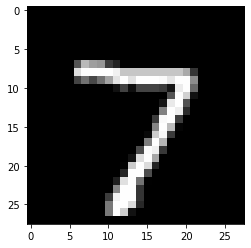

In [10]:
imshow(img[0].reshape(N, N), label=label[0].item())

# Activations

In [11]:
class Tanh():
    def forward(self, x):
        self.old_y = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return self.old_y
    
    def backward(self, grad):
        return (1 - self.old_y**2) * grad

In [12]:
class Sigmoid():
    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad

In [13]:
class ReLU():
    def forward(self, x):
        self.old_x = np.copy(x)
        return np.clip(x,0,None)

    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)

In [14]:
class Softmax():
    def forward(self,x):
        self.old_y = np.exp(x) / np.exp(x).sum(axis=1)[:,None]
        return self.old_y

    def backward(self,grad):
        return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

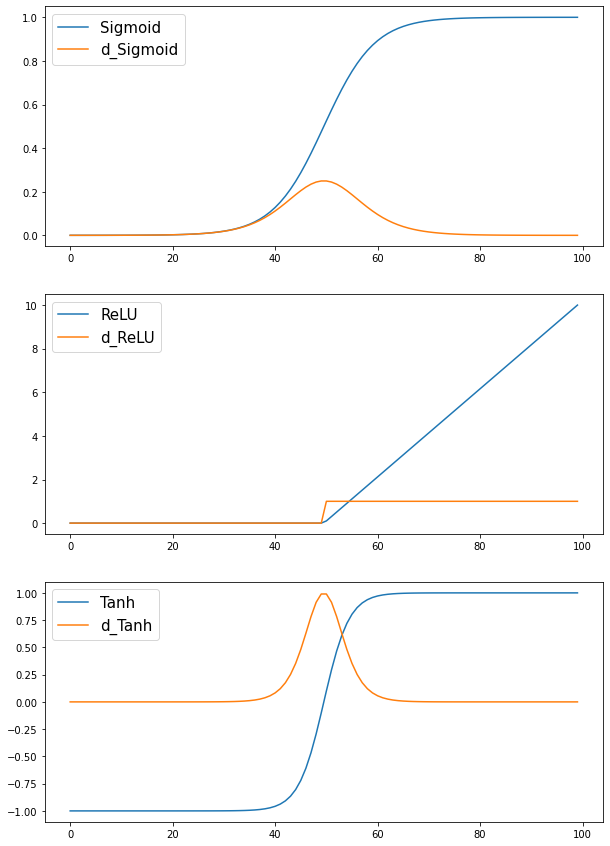

In [15]:
activations = [Sigmoid(), ReLU(), Tanh()]
fig, axs = plt.subplots(nrows=len(activations), figsize=(10, 15))
x = np.linspace(-10, 10, 100)

for i, activation in enumerate(activations):
    axs[i].plot(activation.forward(x))
    axs[i].plot(activation.backward(1))
    axs[i].legend([activation.__class__.__name__, 'd_'+ activation.__class__.__name__], prop={'size': 15})

# Costs

In [31]:
class MSE():
    def forward(self, x, y):
        self.old_x = x
        self.old_y = y
        return (1/2 * np.square(x-y)).mean()
    
    def backward(self):
        return (self.old_x - self.old_y).mean(axis=0)

In [5]:
class CrossEntropy():
    def forward(self,x,y):
        self.old_x = x.clip(min=1e-10,max=None)
        self.old_y = y
        return (np.where(y==1,-np.log(self.old_x), 0)).mean()

    def backward(self):
        return np.where(self.old_y==1,-1/self.old_x, 0).mean(axis=0)

In [59]:
x = np.random.rand(8, 10)

In [60]:
y = np.random.rand(8, 10)

In [61]:
cost = CrossEntropy()

In [62]:
cost.forward(x, y)

0.0

In [63]:
cost.backward().shape

(10,)

# Net layer

In [65]:
class Linear():
    def __init__(self,n_in,n_out):
        self.w = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
        self.b = np.zeros(n_out)

    def forward(self, x):
        self.old_x = x
        return np.dot(x,self.w) + self.b

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = self.old_x.T @ grad
        return np.dot(grad, self.w.T)

# Optimizer

In [66]:
class SGD():
    def __init__(self, lr=0.01, weight_decay=0):
        self.lr = lr
        self.weight_decay = weight_decay

    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]

    def step(self):
        for layer in self.layers:
            layer.grad_w += self.weight_decay * layer.w
            layer.w -= self.lr * layer.grad_w
            layer.b -= self.lr * layer.grad_b

In [67]:
class Momentum():
    def __init__(self, lr=0.01, momentum=0.6, weight_decay=0):
        self.m = momentum
        self.weight_decay = weight_decay        
        self.lr = lr
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.velocity_w = []
        self.velocity_b = []
        for l in self.layers:
            self.velocity_w.append(np.zeros_like(l.w))
            self.velocity_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * layer.grad_w
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * layer.grad_b
            layer.w -= self.velocity_w[i]
            layer.b -= self.velocity_b[i]

In [68]:
class Nesterov():
    def __init__(self, lr=0.01, momentum=0.6, weight_decay=0):
        self.m = momentum
        self.weight_decay = weight_decay
        self.lr = lr
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.velocity_w = []
        self.velocity_b = []
        for l in self.layers:
            self.velocity_w.append(np.zeros_like(l.w))
            self.velocity_b.append(np.zeros_like(l.b))
        
    def step(self):
        model_ahead =  deepcopy(model)
        ahead_layers = [l  for l in model_ahead.layers if type(l) == Linear]
        
        for i, layer in enumerate(ahead_layers):
            layer.w -= self.m * self.velocity_w[i] 
            layer.b -= self.m * self.velocity_b[i]
        
        
        model_ahead.loss(self.model.cur_x, self.model.cur_y)
        model_ahead.backward()
        
        ahead_layers = [l  for l in model_ahead.layers if type(l) == Linear]
        
        for i, t in enumerate(zip(ahead_layers, self.layers)):
            ahead_layer, layer = t
            layer.grad_w += self.weight_decay * layer.w
            
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * ahead_layer.grad_w
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * ahead_layer.grad_b
            
            layer.w -= self.velocity_w[i]
            layer.b -= self.velocity_b[i]

In [69]:
class AdaGrad():
    def __init__(self, lr=1, weight_decay=0):
        self.lr = lr
        self.weight_decay = weight_decay
        self.eps = 1e-10

    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w
            
            self.N_w[i] += layer.grad_w ** 2 
            self.N_b[i] += layer.grad_b ** 2
            
            layer.w -= self.lr * layer.grad_w / (np.sqrt(self.N_w[i]) + self.eps)
            layer.b -= self.lr * layer.grad_b / (np.sqrt(self.N_b[i]) + self.eps)

In [70]:
class RMSprop():
    def __init__(self, lr=0.01, decay=0.9, weight_decay=0):
        self.lr = lr
        self.decay = decay
        self.weight_decay = weight_decay

        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w
            
            self.N_w[i] = self.decay * self.N_w[i] + (1-self.decay) * layer.grad_w ** 2
            self.N_b[i] = self.decay * self.N_b[i] + (1-self.decay) * layer.grad_b ** 2
            
            layer.w -= self.lr * layer.grad_w / (np.sqrt(self.N_w[i]) + self.eps)
            layer.b -= self.lr * layer.grad_b / (np.sqrt(self.N_b[i]) + self.eps)

In [71]:
class AdaDelta():
    def __init__(self, lr=0.01, decay=0.9, weight_decay=0):
        self.lr = lr
        self.decay = decay
        self.weight_decay = weight_decay
        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        
        self.P_w = []
        self.P_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
            self.P_w.append(np.zeros_like(l.w))
            self.P_b.append(np.zeros_like(l.b))
            

    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w
            
            self.N_w[i] = self.decay * self.N_w[i] + (1-self.decay)*layer.grad_w ** 2 
            self.N_b[i] = self.decay * self.N_b[i] + (1-self.decay)*layer.grad_b ** 2

            d_w = layer.grad_w * np.sqrt(self.P_w[i] + self.eps) / np.sqrt(self.N_w[i] + self.eps)
            d_b = layer.grad_b * np.sqrt(self.P_b[i] + self.eps) / np.sqrt(self.N_b[i] + self.eps)

            self.P_w[i] = self.decay * self.P_w[i] + (1 - self.decay) * d_w ** 2
            self.P_b[i] = self.decay * self.P_b[i] + (1 - self.decay) * d_b ** 2
            layer.w -= self.lr * d_w
            layer.b -= self.lr * d_b

In [72]:
class Adam():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, weight_decay=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.weight_decay = weight_decay
        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b


            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)


            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)

In [73]:
class AdaMax():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, weight_decay=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.weight_decay = weight_decay
        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b


            self.N_w[i] = max(self.beta2 * self.N_w[i], abs(layer.grad_w) + self.eps, key=np.linalg.norm)
            self.N_b[i] = max(self.beta2 * self.N_b[i], abs(layer.grad_b) + self.eps, key=np.linalg.norm)
            

            layer.w -= self.lr * self.M_w[i] / (self.N_w[i] * (1 - self.beta1 ** t))
            layer.b -= self.lr * self.M_b[i] / (self.N_b[i] * (1 - self.beta1 ** t))

In [74]:
class NAdam():
    def __init__(self, lr=0.002, beta1=0.9, beta2=0.999, momentum_decay=0.004, weight_decay=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.momentum_decay = momentum_decay
        self.weight_decay = weight_decay
        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        self.N_w = []
        self.N_b = []
        self.mus = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w
            
            mu = self.beta1 * (1 - 0.5 * 0.96**((t)*self.momentum_decay))
            mu_n = self.beta1 * (1 - 0.5 * 0.96**((t+1)*self.momentum_decay))
            
            self.mus.append(mu)
            
            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b
            
            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            m_w_hat = mu_n*self.M_w[i] / (1-np.prod(self.mus + [mu_n])) - (1-mu)*layer.grad_w / (1-np.prod(self.mus))   
            m_b_hat = mu_n*self.M_b[i] / (1-np.prod(self.mus + [mu_n])) - (1-mu)*layer.grad_b / (1-np.prod(self.mus))   
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)
            
            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)


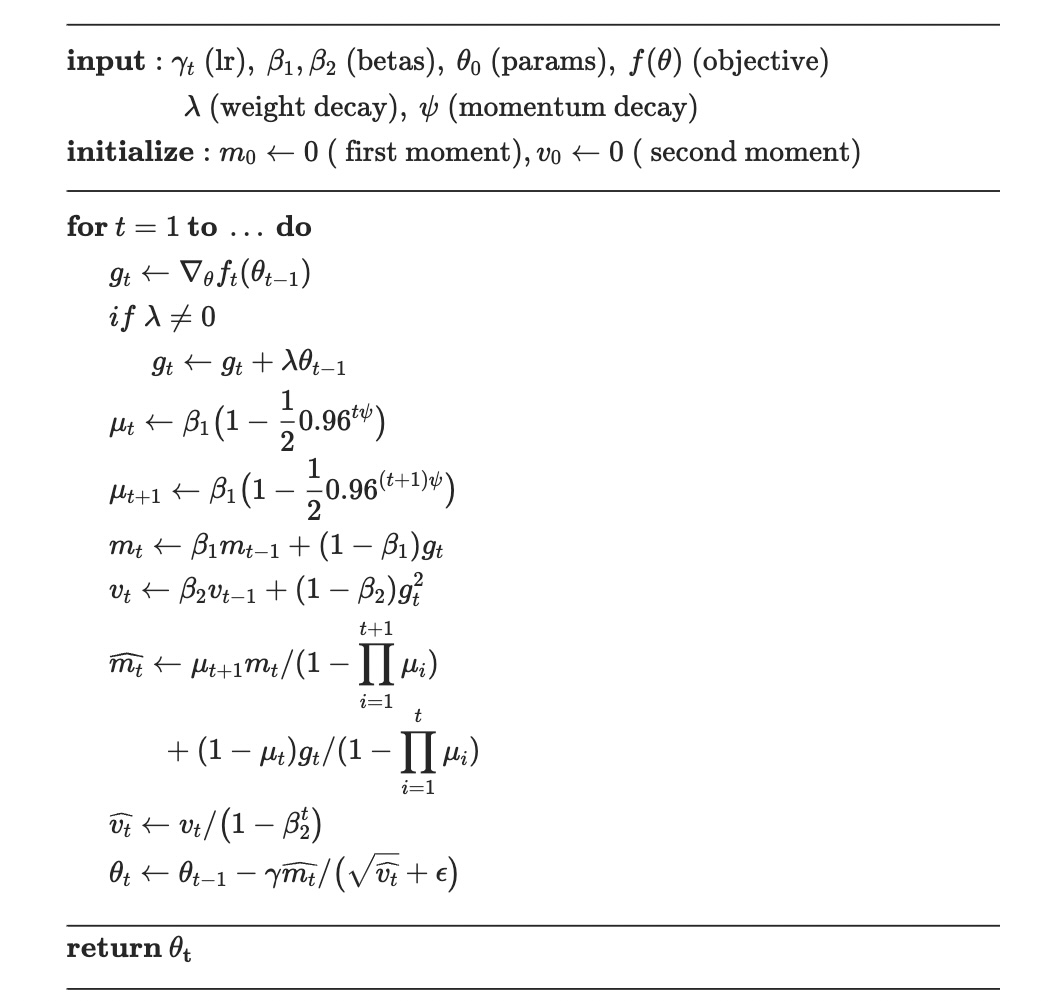

In [75]:
class AMSGrad():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, weight_decay=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.weight_decay = weight_decay
        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        self.prev_n_w_hat = 0
        self.prev_n_b_hat = 0
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.weight_decay * layer.w

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b

            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            
            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)


            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)

# Model 

In [76]:
class Model():
    def __init__(self, layers, cost, optimizer):
        self.layers = layers
        self.cost = cost
        self.optimizer = optimizer
        self.optimizer.init_params(self)
        
    def one_hot(self, label):
        return np.eye(10)[label]
    
    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x), y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

    def train(self, train_loader, test_loader, epochs, num_samples=10_000):
        samples = 0
        accs = []
        losses = []
        for epoch in tqdm(range(epochs)):
            self.cur_epoch = epoch
            for img, label in train_loader:
                bs = img.shape[0]
                y = self.one_hot(label)
                x = img.numpy()
                self.cur_x = x
                self.cur_y = y

                self.loss(x, y)
                self.backward()

                self.optimizer.step()
                
                samples += bs
                if samples > num_samples:
                    break
            
            acc, loss = self.validate(test_loader)
            accs.append(acc)
            losses.append(loss)
        return accs, losses
    
    def validate(self, loader):
        losses = []
        acc = 0
        counter = 0
        for img, label in loader:
            bs = img.shape[0]
            y = self.one_hot(label)
            x = img.numpy()
            
            preds = np.argmax(np.array(self.forward(x)), axis=1)
            labels = label.numpy()
            
            acc += sum(labels == preds)
            counter += bs
            
            losses.append(self.loss(x, y))
        return acc / counter, np.mean(losses)

In [77]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [84]:
EPOCHS = 100
NUM_SAMPLES = 1_000
LR = 0.002

In [85]:
OPTIMIZERS = [
    SGD(LR),
    Momentum(LR, momentum=0.6),
    Nesterov(LR, momentum=0.6),
    AdaGrad(LR),
    AdaDelta(lr=1),
    RMSprop(LR, decay=0.9),
    Adam(LR, beta1=0.9, beta2=0.99),
#     AdaMax(LR, beta1=0.9, beta2=0.99),
#     NAdam(LR)
]

In [86]:
acc_map = dict()
loss_map = dict()

# Train

In [96]:
model = Model(
    layers=[Linear(784, 10), Sigmoid()], 
    cost=MSE(),
    optimizer=SGD(0.1)
)
acc, loss = model.train(train_loader, test_loader, EPOCHS, num_samples=NUM_SAMPLES)
plt.plot(acc)

In [38]:
for opt in OPTIMIZERS:
    model = Model(
        layers=[Linear(784, 10), Sigmoid()], 
        cost=MSE(),
        optimizer=opt
    )
    opt_name = opt.__class__.__name__
    print(f'start train for {opt_name}')
    acc, loss = model.train(train_loader, test_loader, EPOCHS, num_samples=NUM_SAMPLES)
    acc_map[opt_name] = acc
    loss_map[opt_name] = loss

start train for RMSprop


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

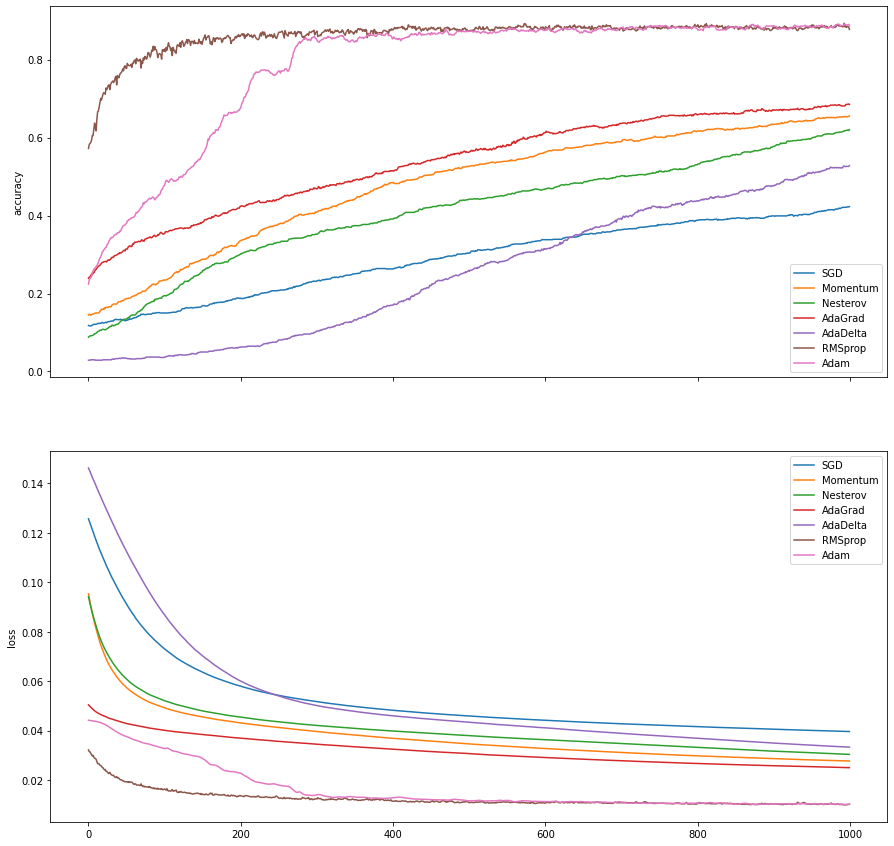

In [42]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
names = [opt.__class__.__name__ for opt in OPTIMIZERS]
for name in names:
    axs[0].plot(acc_map[name])
    axs[0].legend(names, prop={'size': 10})
    axs[0].set(ylabel='accuracy')
    axs[1].plot(loss_map[name])
    axs[1].set(ylabel='loss')
    axs[1].legend(names, prop={'size': 10})
for ax in axs.flat:
    ax.label_outer()


# Save results

In [60]:
# with open('acc.json', 'w') as f:
#     json.dump(acc_map, f)
# with open('loss.json', 'w') as f:
#     json.dump(loss_map, f)
# fig.savefig('results.png')

# Load results

In [39]:
# with open('acc.json', 'r') as f:
#     acc_map = json.load(f)
# with open('loss.json', 'r') as f:
#     loss_map = json.load(f)

In [ ]:
model = Model(
    layers=[Linear(784, 10), Sigmoid()], 
    cost=MSE(),
    optimizer=NAdam()
)
acc, loss = model.train(train_loader, test_loader, EPOCHS, num_samples=NUM_SAMPLES)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
